# VCs Characteristics exploration

## Data ETL

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
from networkx.algorithms.community import greedy_modularity_communities

# warnings.filterwarnings('ignore')

import sys

sys.path.append('../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

country = "us"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


In [19]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [20]:
early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'])
min_year = 2004
max_year = 2024

early_stage_mask = vc_investments['investment_type'].isin(early_stages)
late_stage_mask = vc_investments['investment_type'].isin(late_stages)

# Create left and right
right_investments = vc_investments[
  (early_stage_mask)
]

left_investments = vc_investments[
  (late_stage_mask)
]

investments_pairs = create_investment_pairs(left_investments, right_investments, 'left', 'right')
investments_pairs['announced_year'] = investments_pairs[['announced_year_left', 'announced_year_right']].max(axis=1)
investments_pairs['year'] = investments_pairs['announced_year']
investments_pairs['total_funding_usd'] = investments_pairs['total_funding_usd_left']
investments_pairs['company_country'] = investments_pairs['company_country_left']
investments_pairs['category'] = investments_pairs['category_left']

Created 169679 investment pairs
Covering 3666 unique statups


In [21]:
investments_pairs_clean = investments_pairs[[
    'investor_name_left',
    'investor_name_right',
    'announced_year_left',
    'announced_year_right', 
    'org_uuid',
    'total_funding_usd',
    'total_funding_usd_left',
    'total_funding_usd_right',
    'year',
    'total_funding_usd',
    'company_country',
    'investor_country_left',
    'investor_country_right',
    'investment_type_left',
    'investment_type_right',
    'category_left',
    'category_right',
]].copy()

investments_pairs_clean = investments_pairs_clean.dropna(subset=['year'])
investments_pairs_clean = investments_pairs_clean[(investments_pairs_clean['year'] >= min_year) & (investments_pairs_clean['year'] <= max_year)]

# Filter out pairs where the VCs might be related (first 5 characters of names match)
investments_pairs_clean = investments_pairs_clean[
    investments_pairs_clean['investor_name_left'].str[:5] != 
    investments_pairs_clean['investor_name_right'].str[:5]
]

## Bipartite Network Analysis

### Create bipartite graph

In [23]:
bipartite_graph = create_bipartite_graph(investments_pairs_clean, 'investor_name_left', 'investor_name_right', None, 'left', 'right')
bipartite_sets = get_bipartite_sets(bipartite_graph)

set_0 = bipartite_sets['set_0']
set_1 = bipartite_sets['set_1']

### Identify communities

In [ ]:
G = bipartite_graph.copy()
max_communities = 15

cummunities = list(greedy_modularity_communities(G))
len(cummunities)

168

In [ ]:
max_top_communities = 10

top_communities = sorted(cummunities, key=lambda x: len(x), reverse=True)[:max_top_communities]
print("Top 5 investor communities by size:")
for c_idx, top_community in enumerate(top_communities):
    print(f"Community {c_idx}: {len(top_community)} investors")
    
color_map = {}
for c_idx, community in enumerate(cummunities):
    comm_size = len(community)
    for node in community:
        color_map[node] = c_idx

colors = [color_map[node] for node in G.nodes]
unique_colors = sorted(set(colors))

Top 5 investor communities by size:
Community 0: 4248 investors
Community 1: 4089 investors
Community 2: 3959 investors
Community 3: 979 investors
Community 4: 188 investors
Community 5: 155 investors
Community 6: 137 investors
Community 7: 122 investors
Community 8: 64 investors
Community 9: 64 investors


In [ ]:
PLOT_KKL = False

if PLOT_KKL:
    plt.figure(figsize=(12, 10))

    pos = nx.kamada_kawai_layout(G)
    color_map = plt.cm.Set1  # Use a color palette with distinct colors

    # Draw the graph with improved visibility
    nx.draw(G, pos, 
    node_color=colors, 
    node_size=20,  # Increased for better visibility
    width=0.2,     # Slightly thicker edges
    cmap=color_map,
    with_labels=False,
    alpha=0.8)

    # Create a legend map
    legend_elements = []
    for i, comm_idx in enumerate(unique_colors[:10]):  # Limit to top 10 for readability
        comm_size = colors.count(comm_idx)
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
            label=f'Community {comm_idx} ({comm_size} nodes)',
            markerfacecolor=color_map(comm_idx), 
            markersize=10))

    plt.legend(handles=legend_elements, loc='upper right', title='Investor Communities')
    plt.title("Clusters of investors detected via communities", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Analyse communities

#### Nestdness

In [ ]:
MEASURE_NESTEDNESS = False

if MEASURE_NESTEDNESS:
    # Initialize storage for community nestedness results
    community_nestedness_results = []

    # Parameters for null model analysis
    n_iterations = 100  # Number of null models to generate
    n_iterations_cv = 10000  # Number of curveball iterations
    min_community_size = 100  # Minimum nodes required for analysis

    print(f"Analyzing nestedness for {len(top_communities)} communities...")
    print("=" * 60)

    for comm_idx, community in enumerate(top_communities):
        if len(community) < min_community_size:
            print(f"Community {comm_idx}: Skipping (only {len(community)} nodes)")
            continue
        
        try:
            # Extract subgraph for this community
            subgraph = bipartite_graph.subgraph(community)
            
            # Get bipartite sets for this community
            community_set_0 = [node for node in community if node in set_0]
            community_set_1 = [node for node in community if node in set_1]
            
            # Skip if either set is empty
            if len(community_set_0) == 0 or len(community_set_1) == 0:
                print(f"Community {comm_idx}: Skipping (empty bipartite set)")
                continue
            
            print(f"Community {comm_idx}: {len(community_set_0)} left nodes, {len(community_set_1)} right nodes")
            
            # Create adjacency matrix for this community
            left_indices = {node: i for i, node in enumerate(community_set_0)}
            right_indices = {node: j for j, node in enumerate(community_set_1)}
            
            # Initialize adjacency matrix
            community_adjacency_matrix = np.zeros((len(community_set_0), len(community_set_1)))
            
            # Fill matrix with connections within this community
            for left_node in community_set_0:
                for right_node in community_set_1:
                    if subgraph.has_edge(left_node, right_node):
                        left_idx = left_indices[left_node]
                        right_idx = right_indices[right_node]
                        community_adjacency_matrix[left_idx, right_idx] = 1
            
            # Calculate observed nestedness
            calculator = NestednessCalculator(community_adjacency_matrix)
            nestedness_score = calculator.nodf(community_adjacency_matrix)
            
            # Calculate basic network metrics
            num_edges = int(community_adjacency_matrix.sum())
            density = community_adjacency_matrix.mean()
            
            print(f"  Observed nestedness (NODF): {nestedness_score:.4f}")
            print(f"  Edges: {num_edges}, Density: {density:.4f}")
            
            # Generate null models if there are enough edges
            if num_edges < 5:
                print(f"  Skipping null model analysis (too few edges: {num_edges})")
                community_nestedness_results.append({
                    'community_id': comm_idx,
                    'community_size': len(community),
                    'left_nodes': len(community_set_0),
                    'right_nodes': len(community_set_1),
                    'num_edges': num_edges,
                    'density': density,
                    'observed_nestedness': nestedness_score,
                    'null_mean': np.nan,
                    'null_std': np.nan,
                    'z_score': np.nan,
                    'p_value': np.nan,
                    'significance': 'insufficient_data'
                })
                continue
            
            # Generate null models using curveball algorithm
            null_nestedness_scores = []
            
            print(f"  Generating {n_iterations} null models...")
            for i in tqdm(range(n_iterations), desc=f"Community {comm_idx}"):
                try:
                    # Generate null model matrix by swapping while preserving degrees
                    M = community_adjacency_matrix.copy()
                    r_hp = find_presences(M)
                    RM = curve_ball(M, r_hp, n_iterations_cv)
                    
                    null_matrix = RM.astype(community_adjacency_matrix.dtype)
                    
                    # Calculate nestedness of the null model
                    calculator_null = NestednessCalculator(null_matrix)
                    null_score = calculator_null.nodf(null_matrix)
                    null_nestedness_scores.append(null_score)
                    
                except Exception as e:
                    print(f"    Error in null model iteration {i}: {e}")
                    continue
            
            # Calculate statistical significance
            if len(null_nestedness_scores) > 0:
                null_nestedness_scores_np = np.array(null_nestedness_scores)
                mean_null = np.mean(null_nestedness_scores_np)
                std_null = np.std(null_nestedness_scores_np)
                
                if std_null > 0:
                    z_score = (nestedness_score - mean_null) / std_null
                else:
                    z_score = np.nan
                
                p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)
                significance = 'significant' if p_value < 0.05 else 'not_significant'
                
                print(f"  Null model mean: {mean_null:.4f} ± {std_null:.4f}")
                print(f"  Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
            else:
                mean_null = std_null = z_score = p_value = np.nan
                significance = 'null_model_failed'
                print(f"  Warning: No valid null models generated")
            
            # Store results
            community_nestedness_results.append({
                'community_id': comm_idx,
                'community_size': len(community),
                'left_nodes': len(community_set_0),
                'right_nodes': len(community_set_1),
                'num_edges': num_edges,
                'density': density,
                'observed_nestedness': nestedness_score,
                'null_mean': mean_null,
                'null_std': std_null,
                'z_score': z_score,
                'p_value': p_value,
                'significance': significance,
                'null_scores': null_nestedness_scores if len(null_nestedness_scores) > 0 else []
            })
            
        except Exception as e:
            print(f"Community {comm_idx}: Error - {str(e)}")
            continue

    print(f"\nAnalyzed {len(community_nestedness_results)} communities successfully")

In [ ]:
if MEASURE_NESTEDNESS:
    # Convert results to DataFrame for analysis
    community_nestedness_df = pd.DataFrame(community_nestedness_results)

    if len(community_nestedness_df) > 0:
        print("Community Nestedness Analysis Summary:")
        print("=" * 50)
        print(f"Total communities analyzed: {len(community_nestedness_df)}")
        print(f"Significant communities (p < 0.05): {len(community_nestedness_df[community_nestedness_df['significance'] == 'significant'])}")
        
        # Display summary statistics
        print("\nNestedness Statistics:")
        valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
        if len(valid_results) > 0:
            print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
            print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
            print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
    else:
        print("No communities were successfully analyzed")

In [ ]:
if MEASURE_NESTEDNESS:
    # Visualize community nestedness results
    if len(community_nestedness_df) > 0:
        valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
        
        if len(valid_results) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Community Nestedness Analysis Results', fontsize=16, fontweight='bold')
            
            # Plot 1: Observed vs Null Nestedness
            axes[0, 0].scatter(valid_results['null_mean'], valid_results['observed_nestedness'], 
                            c=valid_results['p_value'], s=valid_results['community_size']*2, 
                            cmap='RdYlBu_r', alpha=0.7)
            axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
            axes[0, 0].set_xlabel('Null Model Mean Nestedness')
            axes[0, 0].set_ylabel('Observed Nestedness')
            axes[0, 0].set_title('Observed vs Null Nestedness\n(Color: p-value, Size: community size)')
            
            # Plot 2: Distribution of Z-scores
            axes[0, 1].hist(valid_results['z_score'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 1].axvline(0, color='red', linestyle='--', label='Z=0')
            axes[0, 1].axvline(1.96, color='orange', linestyle='--', label='Z=1.96 (p=0.05)')
            axes[0, 1].axvline(-1.96, color='orange', linestyle='--')
            axes[0, 1].set_xlabel('Z-score')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Distribution of Nestedness Z-scores')
            axes[0, 1].legend()
            
            # Plot 3: Community size vs Nestedness
            significant_mask = valid_results['significance'] == 'significant'
            axes[1, 0].scatter(valid_results[~significant_mask]['community_size'], 
                            valid_results[~significant_mask]['observed_nestedness'],
                            c='lightcoral', alpha=0.6, label='Not significant')
            axes[1, 0].scatter(valid_results[significant_mask]['community_size'], 
                            valid_results[significant_mask]['observed_nestedness'],
                            c='darkgreen', alpha=0.8, label='Significant')
            axes[1, 0].set_xlabel('Community Size')
            axes[1, 0].set_ylabel('Observed Nestedness')
            axes[1, 0].set_title('Community Size vs Nestedness')
            axes[1, 0].legend()
            
            # Plot 4: P-value distribution
            axes[1, 1].hist(valid_results['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[1, 1].axvline(0.05, color='red', linestyle='--', label='α=0.05')
            axes[1, 1].set_xlabel('P-value')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Distribution of P-values')
            axes[1, 1].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Create detailed plots for significant communities
            significant_communities = valid_results.head(5)
            
            if len(significant_communities) > 0:
                print(f"\nDetailed analysis for top {len(significant_communities)} significant communities:")
                fig, axes = plt.subplots(len(significant_communities), 2, 
                                    figsize=(16, 4*len(significant_communities)))
                if len(significant_communities) == 1:
                    axes = axes.reshape(1, -1)
                
                for i, (_, row) in enumerate(significant_communities.iterrows()):
                    comm_idx = row['community_id']
                    null_scores = row['null_scores']
                    
                    if len(null_scores) > 0:
                        # Histogram of null model distribution
                        sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
                        axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                                        linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
                        axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                                        linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
                        axes[i, 0].set_title(f'Community {comm_idx} Null Model Analysis\n'
                                            f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.4f}')
                        axes[i, 0].set_xlabel('Nestedness (NODF)')
                        axes[i, 0].set_ylabel('Frequency')
                        axes[i, 0].legend()
                    
                    # Bar plot of community structure
                    axes[i, 1].bar(['Left Nodes', 'Right Nodes'], 
                                [row['left_nodes'], row['right_nodes']], 
                                color=['lightblue', 'lightcoral'])
                    axes[i, 1].set_title(f'Community {comm_idx} Structure\n'
                                        f'Total size: {row["community_size"]}, Edges: {row["num_edges"]}')
                    axes[i, 1].set_ylabel('Number of Nodes')
                
                plt.tight_layout()
                plt.show()
        else:
            print("No valid results available for visualization")
    else:
        print("No data available for visualization")

### Deepdive Communities

In [ ]:
investments_pairs_communities = investments_pairs.copy()
# Create a mapping from investor name to community ID
investor_to_community = {}
for comm_idx, community in enumerate(cummunities):
  for investor in community:
    investor_to_community[investor] = comm_idx

# Add community column for left and right investors
investments_pairs_communities['community_left'] = investments_pairs_communities['investor_name_left'].map(investor_to_community).fillna(-1).astype(int)
investments_pairs_communities['community_right'] = investments_pairs_communities['investor_name_right'].map(investor_to_community).fillna(-1).astype(int)

# A pair is considered to be in a community if both investors are in the same community
investments_pairs_communities['community'] = np.where(
  (investments_pairs_communities['community_left'] == investments_pairs_communities['community_right']) & 
  (investments_pairs_communities['community_left'] != -1),
  investments_pairs_communities['community_left'],
  -1
)

# Drop the intermediate columns
#investments_pairs_communities.drop(columns=['community_left', 'community_right'], inplace=True)

# Print distribution of communities
community_counts = investments_pairs_communities['community'].value_counts()
print(f"Investment pairs assigned to communities: {(investments_pairs_communities['community'] != -1).sum()}")
print(f"Investment pairs not in any community: {(investments_pairs_communities['community'] == -1).sum()}")
print("\nTop 5 communities by number of investment pairs:")
print(community_counts.head())


Investment pairs assigned to communities: 111350
Investment pairs not in any community: 58329

Top 5 communities by number of investment pairs:
community
-1    58329
 2    55863
 0    32164
 1    17301
 3     2904
Name: count, dtype: int64


Community 0: 32164 investment pairs
Community 1: 17301 investment pairs
Community 2: 55863 investment pairs


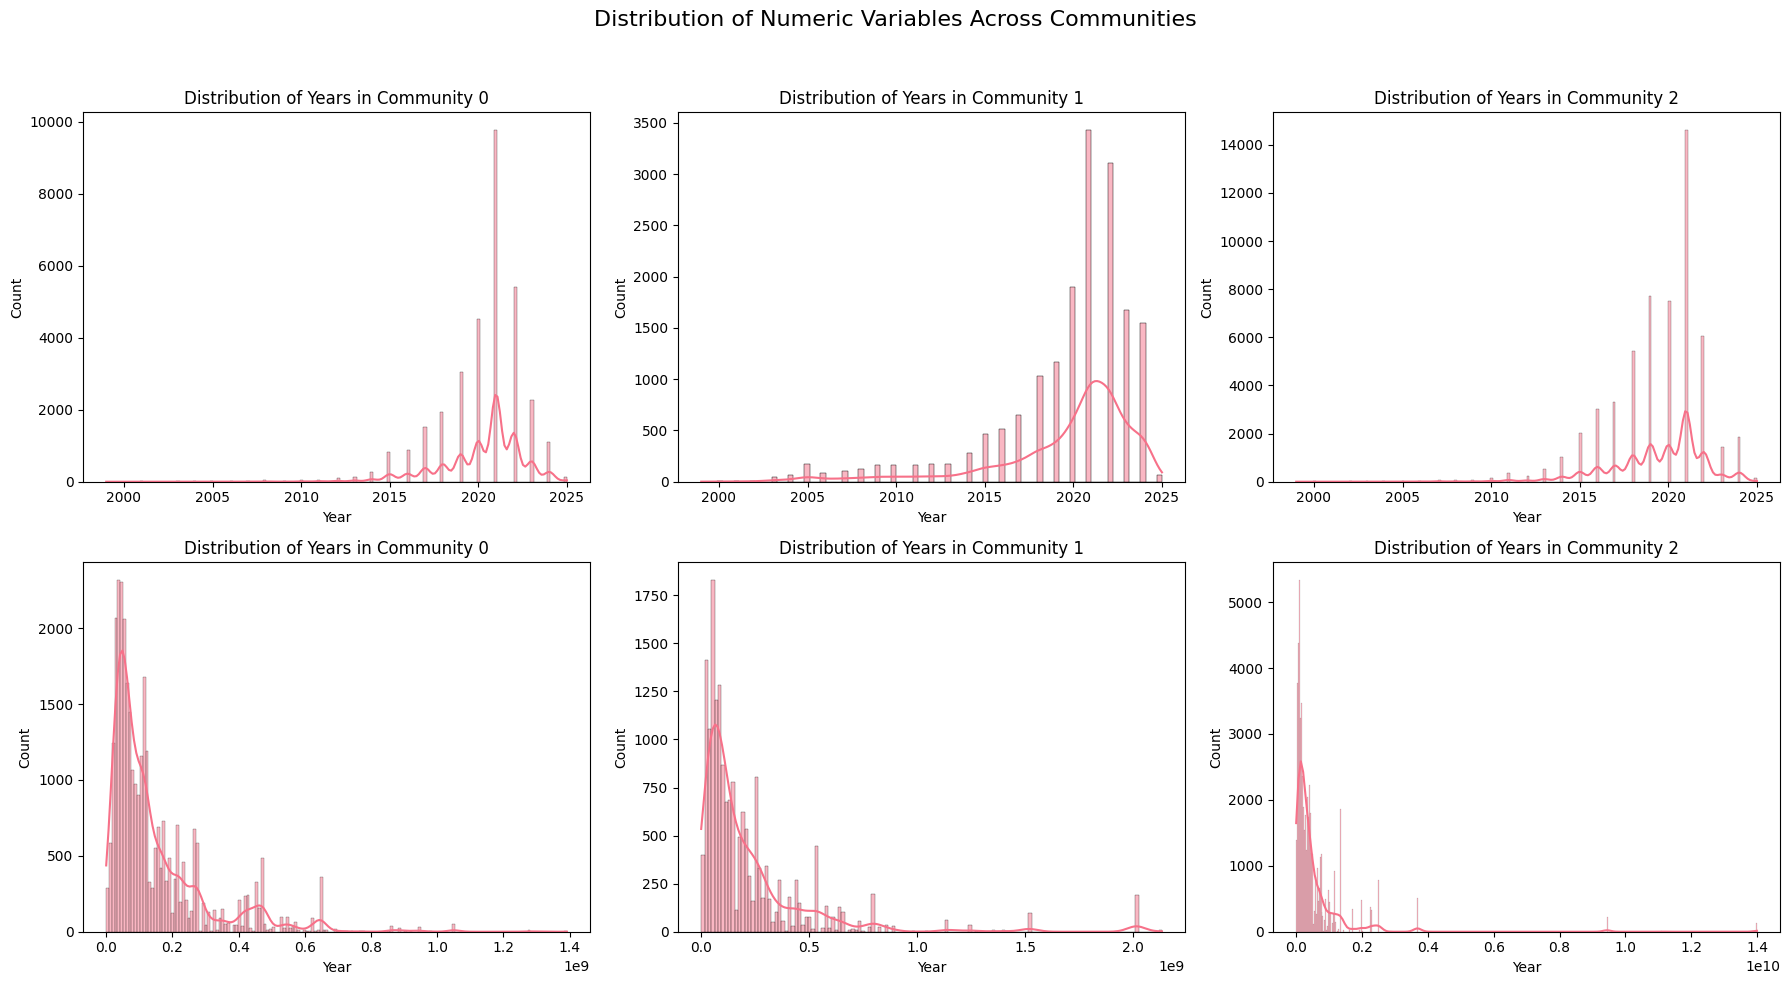

In [ ]:
# Filter the data for communities 0, 1, and 2

community_data = {}
for comm_id in [0, 1, 2, -1]:
  community_data[comm_id] = investments_pairs_communities[investments_pairs_communities['community'] == comm_id]

# Print the sizes of each community
for comm_id in [0, 1, 2, -1]:
  print(f"Community {comm_id}: {len(community_data[comm_id])} investment pairs")

# Function to truncate long category names
def truncate_name(name, max_length=30):
  if isinstance(name, str) and len(name) > max_length:
    return name[:max_length] + '...'
  return name

# Plot numeric columns
numeric_columns = ['year', 'total_funding_usd']
fig, axes = plt.subplots(len(numeric_columns), 3, figsize=(18, 10))
fig.suptitle('Distribution of Numeric Variables Across Communities', fontsize=16)

for row_idx, column in enumerate(numeric_columns):
  for col_idx, comm_id in enumerate([0, 1, 2]):
    ax = axes[row_idx, col_idx]
    data = community_data[comm_id]
    
    if len(data) > 0:
      # if column == 'year':
        sns.histplot(data[column], kde=True, ax=ax)
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of Years in Community {comm_id}')
        
      # elif column == 'total_funding_usd_never':
      #   # Log scale and clip outliers
      #   sns.histplot(data[column].clip(upper=data[column].quantile(0.99)), kde=True, ax=ax)
      #   ax.set_xlabel('Total Funding (USD)')
      #   ax.set_ylabel('Count')
      #   ax.set_title(f'Distribution of Funding in Community {comm_id}')
      #   ax.set_xscale('log')
    else:
      ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
      ax.set_title(f'Community {comm_id}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Figure size 1200x800 with 0 Axes>

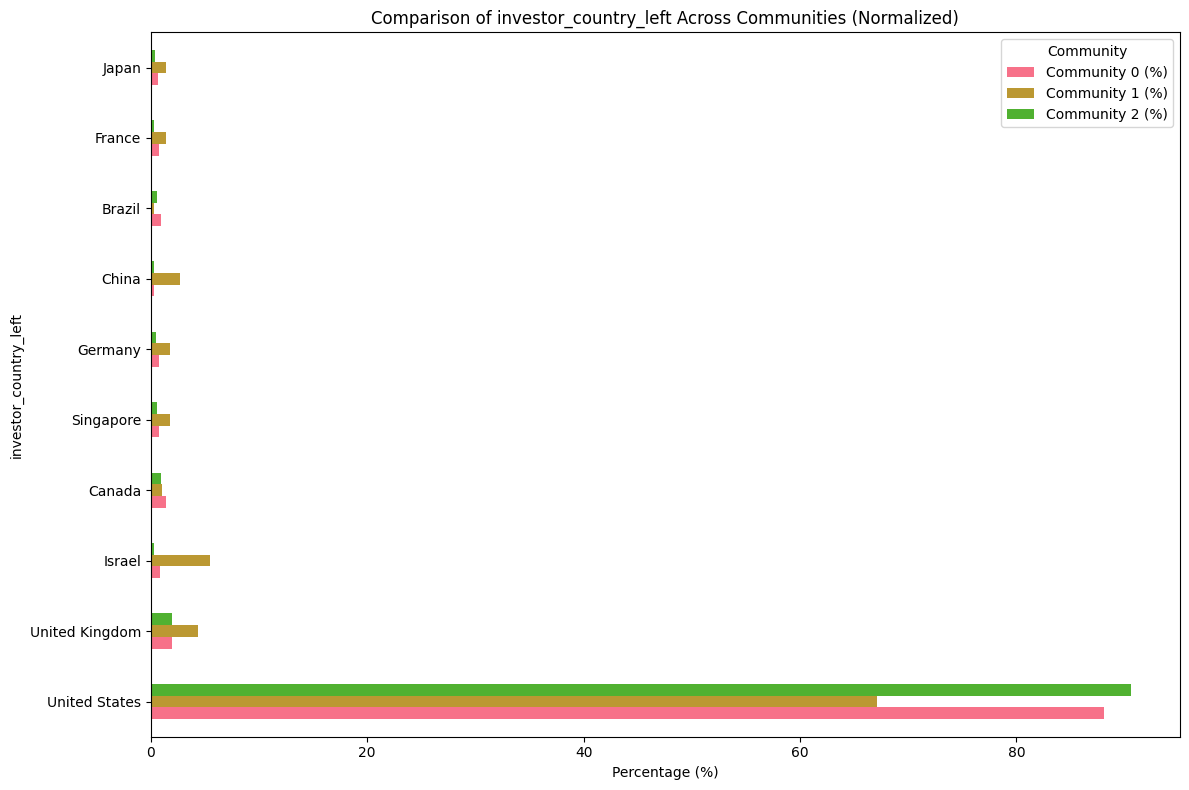

<Figure size 1200x800 with 0 Axes>

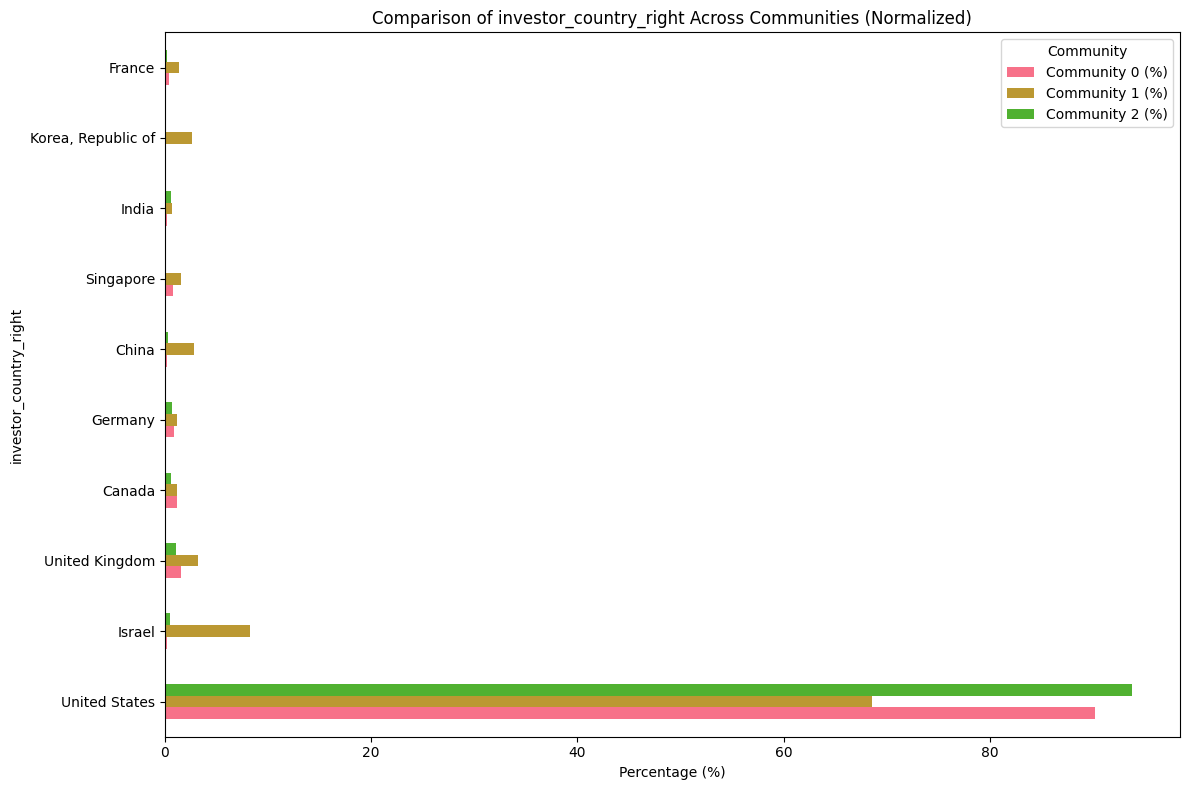

<Figure size 1200x800 with 0 Axes>

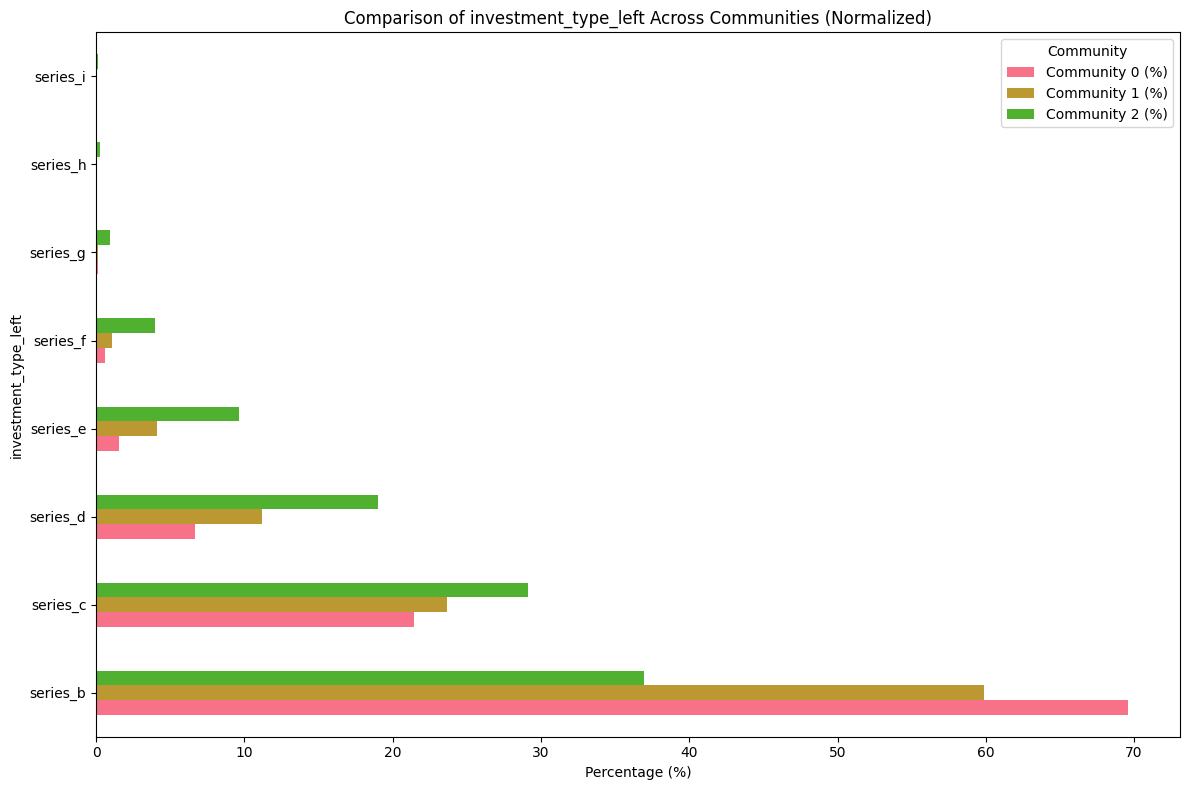

<Figure size 1200x800 with 0 Axes>

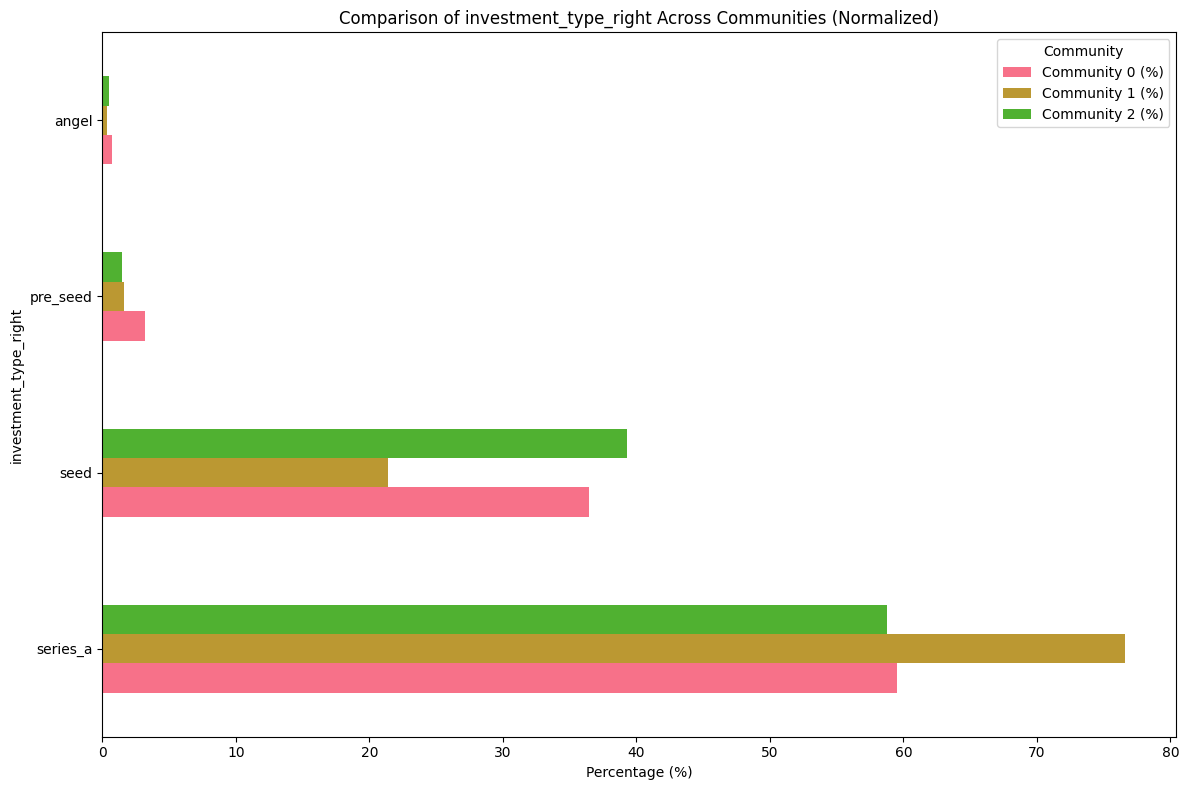

<Figure size 1200x800 with 0 Axes>

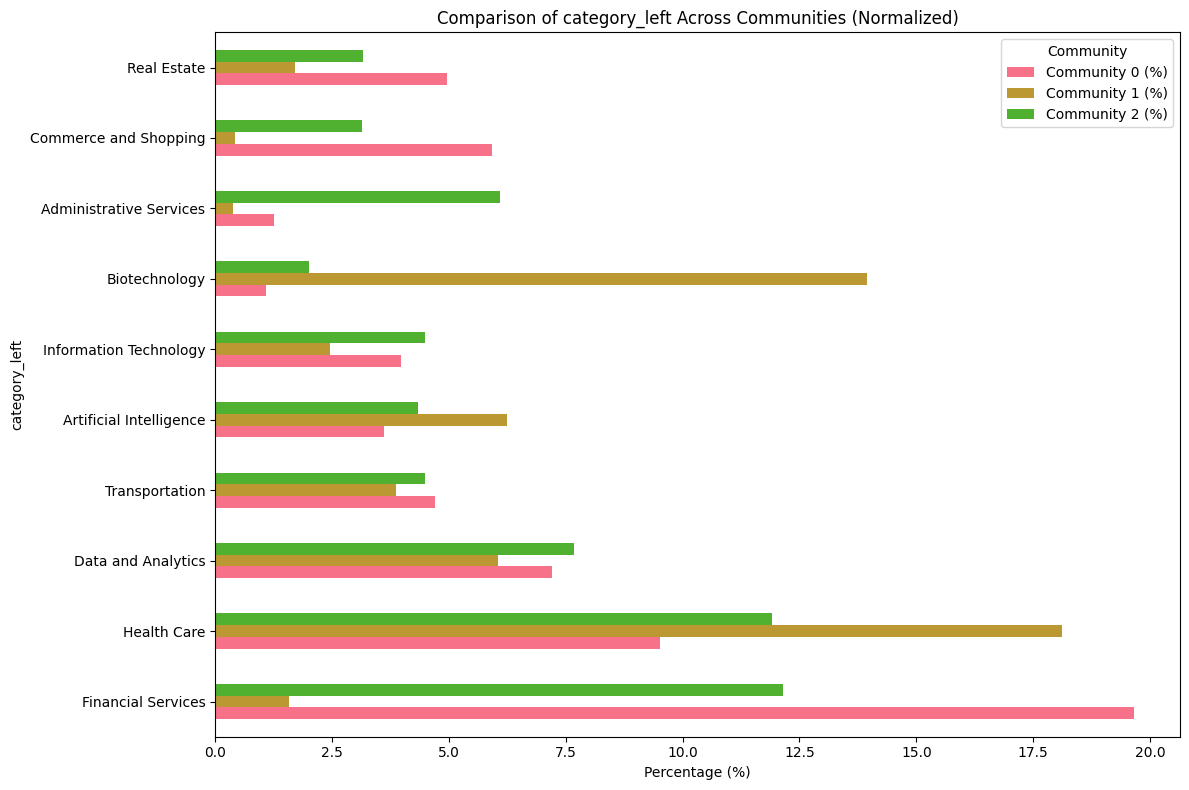

In [25]:
# Plot categorical columns
categorical_columns = [
  'investor_country_left',
  'investor_country_right', 
  'investment_type_left',
  'investment_type_right',
  'category_left'
]

for column in categorical_columns:
  # Get the top 10 categories across all communities
  all_data = pd.concat([community_data[0][column], community_data[1][column], community_data[2][column]])
  top_categories = all_data.value_counts().head(10).index.tolist()
  
  # Create a comparison dataframe
  comparison_df = pd.DataFrame(index=top_categories)
  
  for comm_id in [0, 1, 2]:
    if len(community_data[comm_id]) > 0:
      # Get counts for this community
      counts = community_data[comm_id][column].value_counts()
      # Normalize to percentages
      normalized_counts = counts / len(community_data[comm_id]) * 100
      # Add to comparison df
      comparison_df[f'Community {comm_id} (%)'] = normalized_counts.reindex(comparison_df.index, fill_value=0)
    else:
      comparison_df[f'Community {comm_id} (%)'] = 0
  
  # Truncate long category names
  truncated_index = [truncate_name(cat) for cat in comparison_df.index]
  comparison_df.index = truncated_index
  
  # Plot the comparison
  plt.figure(figsize=(12, 8))
  comparison_df.plot(kind='barh', figsize=(12, 8))
  plt.title(f'Comparison of {column} Across Communities (Normalized)')
  plt.xlabel('Percentage (%)')
  plt.ylabel(column)
  plt.legend(title='Community')
  plt.tight_layout()
  plt.show()